# Modeling and Simulation in Python

Chapter 18

Copyright 2017 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)


In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

### Code from the previous chapter

Read the data.

In [2]:
data = pd.read_csv('data/glucose_insulin.csv', index_col='time');

Interpolate the insulin data.

In [3]:
I = interpolate(data.insulin)

<function modsim.modsim.interpolate.<locals>.wrapper(x)>

### The glucose minimal model

I'll cheat by starting with parameters that fit the data roughly; then we'll see how to improve them.

In [4]:
params = Params(G0 = 290,
                k1 = 0.03,
                k2 = 0.02,
                k3 = 1e-05)

,values
G0,290.00000
k1,0.03000
k2,0.02000
k3,0.00001


Here's a version of `make_system` that takes the parameters and data:

In [5]:
def make_system(params, data):
    """Makes a System object with the given parameters.
    
    params: sequence of G0, k1, k2, k3
    data: DataFrame with `glucose` and `insulin`
    
    returns: System object
    """
    G0, k1, k2, k3 = params
    
    Gb = data.glucose[0]
    Ib = data.insulin[0]
    I = interpolate(data.insulin)
    
    t_0 = get_first_label(data)
    t_end = get_last_label(data)

    init = State(G=G0, X=0)
    
    return System(params,
                  init=init, Gb=Gb, Ib=Ib, I=I,
                  t_0=t_0, t_end=t_end, dt=2)

In [6]:
system = make_system(params, data)

,values
G0,290
k1,0.03
k2,0.02
k3,1e-05
init,G 290.0 X 0.0 dtype: float64
Gb,92
Ib,11
I,<function interpolate.<locals>.wrapper at 0x7f...
t_0,0
t_end,182


And here's the update function.

In [7]:
def update_func(state, t, system):
    """Updates the glucose minimal model.
    
    state: State object
    t: time in min
    system: System object
    
    returns: State object
    """
    G, X = state
    k1, k2, k3 = system.k1, system.k2, system.k3 
    I, Ib, Gb = system.I, system.Ib, system.Gb
    dt = system.dt
        
    dGdt = -k1 * (G - Gb) - X*G
    dXdt = k3 * (I(t) - Ib) - k2 * X
    
    G += dGdt * dt
    X += dXdt * dt

    return State(G=G, X=X)

Before running the simulation, it is always a good idea to test the update function using the initial conditions.  In this case we can veryify that the results are at least qualitatively correct.

In [8]:
update_func(system.init, system.t_0, system)

,values
G,278.12
X,0.00


Now `run_simulation` is pretty much the same as it always is.

In [9]:
def run_simulation(system, update_func):
    """Runs a simulation of the system.
        
    system: System object
    update_func: function that updates state
    
    returns: TimeFrame
    """
    init = system.init
    t_0, t_end, dt = system.t_0, system.t_end, system.dt
    
    frame = TimeFrame(columns=init.index)
    frame.row[t_0] = init
    ts = linrange(t_0, t_end, dt)
    
    for t in ts:
        frame.row[t+dt] = update_func(frame.row[t], t, system)
    
    return frame

And here's how we run it.

In [10]:
results = run_simulation(system, update_func);

The results are in a `TimeFrame` object with one column per state variable.

In [11]:
results

,G,X
0,290.000000,0.000000
2,278.120000,0.000000
4,266.952800,0.000300
6,256.295460,0.002668
8,245.070140,0.004041
10,233.905138,0.004680
12,223.201651,0.005252
14,212.984844,0.005722
16,203.288207,0.006093
18,194.133461,0.006330


The following plot shows the results of the simulation along with the actual glucose data.

Saving figure to file figs/chap18-fig01.pdf


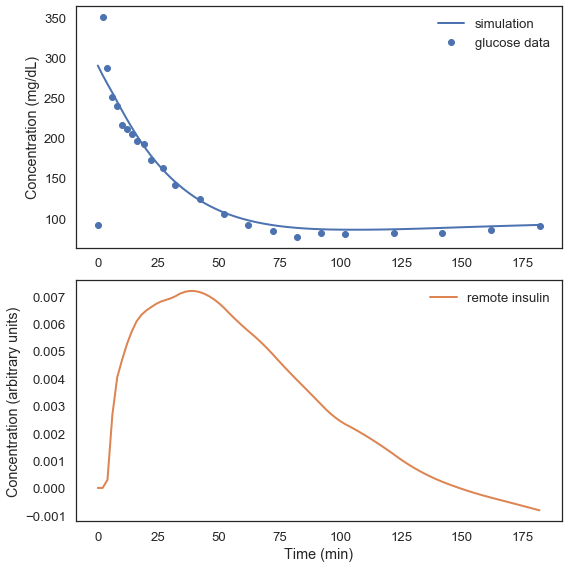

In [12]:
subplot(2, 1, 1)

plot(results.G, 'b-', label='simulation')
plot(data.glucose, 'bo', label='glucose data')
decorate(ylabel='Concentration (mg/dL)')

subplot(2, 1, 2)

plot(results.X, 'C1', label='remote insulin')

decorate(xlabel='Time (min)', 
         ylabel='Concentration (arbitrary units)')

savefig('figs/chap18-fig01.pdf')

### Numerical solution

Now let's solve the differential equation numerically using `run_ode_solver`, which is an implementation of Ralston's method.

Instead of an update function, we provide a slope function that evaluates the right-hand side of the differential equations.

We don't have to do the update part; the solver does it for us.

In [13]:
def slope_func(state, t, system):
    """Computes derivatives of the glucose minimal model.
    
    state: State object
    t: time in min
    system: System object
    
    returns: derivatives of G and X
    """
    G, X = state
    k1, k2, k3 = system.k1, system.k2, system.k3 
    I, Ib, Gb = system.I, system.Ib, system.Gb
    
    dGdt = -k1 * (G - Gb) - X*G
    dXdt = k3 * (I(t) - Ib) - k2 * X
    
    return dGdt, dXdt

We can test the slope function with the initial conditions.

In [14]:
slope_func(system.init, 0, system)

(-5.9399999999999995, 0.0)

Here's how we run the ODE solver.

In [15]:
results2, details = run_ode_solver(system, slope_func)

`details` is a `ModSimSeries` object with information about how the solver worked.

In [16]:
details

,values
success,True
message,The solver successfully reached the end of the...


`results` is a `TimeFrame` with one row for each time step and one column for each state variable:

In [17]:
results2

,G,X
0,290.000000,0.000000
2,278.476400,0.000150
4,267.464465,0.001478
6,255.898956,0.003303
8,244.423982,0.004284
10,233.420932,0.004880
12,222.905305,0.005393
14,212.909446,0.005808
16,203.454111,0.006108
18,194.566003,0.006306


Plotting the results from `run_simulation` and `run_ode_solver`, we can see that they are not very different.

Saving figure to file figs/chap18-fig02.pdf


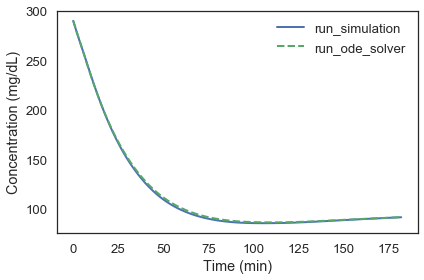

In [18]:
plot(results.G, 'C0', label='run_simulation')
plot(results2.G, 'C2--', label='run_ode_solver')

decorate(xlabel='Time (min)', ylabel='Concentration (mg/dL)')

savefig('figs/chap18-fig02.pdf')

The differences in `G` are less than 2%.

In [19]:
diff = results.G - results2.G
percent_diff = diff / results2.G * 100
percent_diff

0      0.000000
2     -0.127982
4     -0.191302
6      0.154946
8      0.264360
10     0.207439
12     0.132947
14     0.035413
16    -0.081544
18    -0.222312
20    -0.371789
22    -0.522334
24    -0.664226
26    -0.801867
28    -0.934267
30    -1.057014
32    -1.164200
34    -1.256633
36    -1.345996
38    -1.431350
40    -1.511900
42    -1.586993
44    -1.656117
46    -1.718120
48    -1.772875
50    -1.820363
52    -1.860658
54    -1.893922
56    -1.915011
58    -1.925084
         ...   
124   -0.661724
126   -0.631811
128   -0.601917
130   -0.572193
132   -0.542770
134   -0.513756
136   -0.485244
138   -0.457312
140   -0.430024
142   -0.403431
144   -0.377577
146   -0.352881
148   -0.329311
150   -0.306834
152   -0.285416
154   -0.265021
156   -0.245616
158   -0.227165
160   -0.209635
162   -0.192991
164   -0.177201
166   -0.162620
168   -0.149158
170   -0.136734
172   -0.125270
174   -0.114695
176   -0.104943
178   -0.095953
180   -0.087669
182   -0.080037
Name: G, Length: 92, dty

In [20]:
max(abs(percent_diff))

1.9252541088148694

### Exercises

**Exercise:**  Our solution to the differential equations is only approximate because we used a finite step size, `dt=2` minutes.

If we make the step size smaller, we expect the solution to be more accurate.  Run the simulation with `dt=1` and compare the results.  What is the largest relative error between the two solutions?

In [21]:
# Solution

system3 = System(system, dt=1)
results3, details = run_ode_solver(system3, slope_func)
details

,values
success,True
message,The solver successfully reached the end of the...


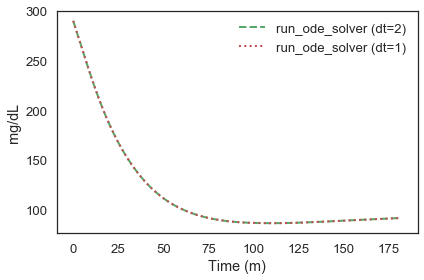

In [22]:
# Solution

plot(results2.G, 'C2--', label='run_ode_solver (dt=2)')
plot(results3.G, 'C3:', label='run_ode_solver (dt=1)')

decorate(xlabel='Time (m)', ylabel='mg/dL')

In [23]:
# Solution

diff = (results2.G - results3.G).dropna()
percent_diff = diff / results2.G * 100

0      0.000000
2      0.009372
4      0.061820
6      0.031912
8      0.012039
10     0.011405
12     0.010124
14     0.009322
16     0.007946
18     0.008430
20     0.009144
22     0.011609
24     0.013346
26     0.015050
28     0.016702
30     0.019412
32     0.021838
34     0.022601
36     0.023359
38     0.024093
40     0.024789
42     0.025433
44     0.026113
46     0.026703
48     0.027200
50     0.027601
52     0.027907
54     0.028811
56     0.029488
58     0.029959
         ...   
124    0.010964
126    0.010626
128    0.010277
130    0.009921
132    0.009561
134    0.009198
136    0.008834
138    0.008472
140    0.008113
142    0.007758
144    0.007359
146    0.006976
148    0.006608
150    0.006255
152    0.005917
154    0.005594
156    0.005284
158    0.004988
160    0.004705
162    0.004434
164    0.004127
166    0.003841
168    0.003574
170    0.003326
172    0.003096
174    0.002881
176    0.002681
178    0.002495
180    0.002322
182    0.002161
Name: G, Length: 92, dty

In [24]:
# Solution

max(abs(percent_diff))

0.061819954534205544

### Under the hood

Here's the source code for `run_ode_solver` if you'd like to know how it works.

Notice that `run_ode_solver` is another name for `run_ralston`, which implements [Ralston's method](https://en.wikipedia.org/wiki/List_of_Runge–Kutta_methods).

In [25]:
source_code(run_ode_solver)

def run_ralston(system, slope_func, **options):
    """Computes a numerical solution to a differential equation.

    `system` must contain `init` with initial conditions,
     and `t_end` with the end time.

     `system` may contain `t_0` to override the default, 0

    It can contain any other parameters required by the slope function.

    `options` can be ...

    system: System object
    slope_func: function that computes slopes

    returns: TimeFrame
    """
    # the default message if nothing changes
    msg = "The solver successfully reached the end of the integration interval."

    # get parameters from system
    init, t_0, t_end, dt = check_system(system, slope_func)

    # make the TimeFrame
    frame = TimeFrame(columns=init.index)
    frame.row[t_0] = init
    ts = linrange(t_0, t_end, dt) * get_units(t_end)

    event_func = options.get('events', None)
    z1 = np.nan

    def project(y1, t1, slopes, dt):
        t2 = t1 + dt
        y2 = [y + slope * dt for y, slop

**Related reading:** You might be interested in this article about [people making a DIY artificial pancreas](https://www.bloomberg.com/news/features/2018-08-08/the-250-biohack-that-s-revolutionizing-life-with-diabetes).